# IADH - DESAFIO 2 

# Versión Final

In [1]:
%autosave 600

Autosaving every 600 seconds


In [2]:
import os
import shutil
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import keras
print(keras.__version__)

/home/carlos/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


2.2.0


# 1. PREPARACIÓN DE AMBIENTES

## Download de datos

In [4]:
BASE_DIR = '/home/carlos/DigitalHouse/desafio'
#BASE_DIR = 'C:/lab3'

In [5]:
os.chdir(BASE_DIR)

In [6]:
%%bash

if [ ! -f imdb_crop.tar ]; then
    wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar
fi
if [ ! -d imdb_crop ]; then
    tar xf imdb_crop.tar
    echo "DATOS IMDB YA ESTAN DISPONIBLES" 
fi

if [ ! -f wiki_crop.tar ]; then
    wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar
fi

if [ ! -d wiki_crop ]; then
    tar xf wiki_crop.tar
    echo "DATOS WIKI YA ESTAN DISPONIBLES"
fi




## Obtención de metadata de las imágenes

In [7]:
def get_metadata(mat_path, db='wiki'):
    meta = loadmat(mat_path)
    full_path = meta[db][0, 0]["full_path"][0]
    gender = meta[db][0, 0]["gender"][0]
    photo_taken = meta[db][0, 0]["photo_taken"][0]  # year
    face_score = meta[db][0, 0]["face_score"][0]
    second_face_score = meta[db][0, 0]["second_face_score"][0]
    df = pd.DataFrame(gender, columns=['gender'])
    df['face1'] = face_score
    df['face2'] = second_face_score
    df['path'] = [x[0] for x in full_path]
    df['nogender'] = np.where(df.gender.isna(), True, False)
    df['noface'] = np.where(df.face1 == -np.inf, True, False)
    df['manyfaces'] = np.where(df.face2.isna(), False, True)
    df['goodface'] = np.where(df.nogender | df.noface | df.manyfaces, False, True)
    df['hombre'] = df.gender == 1.0
    df['mujer'] = df.gender == 0.0
    return df

In [8]:
db = 'imdb'

In [9]:
path = BASE_DIR + "/" + db + "_crop/"+ db + ".mat"
print(path)
meta = get_metadata(path, db)
meta.shape
meta.head()

/home/carlos/DigitalHouse/desafio/imdb_crop/imdb.mat


,gender,face1,face2,path,nogender,noface,manyfaces,goodface,hombre,mujer
0,1.0,1.459693,1.118973,01/nm0000001_rm124825600_1899-5-10_1968.jpg,False,False,True,False,True,False
1,1.0,2.543198,1.852008,01/nm0000001_rm3343756032_1899-5-10_1970.jpg,False,False,True,False,True,False
2,1.0,3.455579,2.985660,01/nm0000001_rm577153792_1899-5-10_1968.jpg,False,False,True,False,True,False
3,1.0,1.872117,NaN,01/nm0000001_rm946909184_1899-5-10_1968.jpg,False,False,False,True,True,False
4,1.0,1.158766,NaN,01/nm0000001_rm980463616_1899-5-10_1968.jpg,False,False,False,True,True,False


In [10]:
m =  meta[meta.goodface & meta.hombre]
f =  meta[meta.goodface & meta.mujer]
print(len(m), len(f))

100002 81688


In [11]:
mi = np.arange(len(m))
fi = np.arange(len(f))
np.random.shuffle(mi)
np.random.shuffle(fi)

## Tamaño de muestras


In [12]:
NB_TRAIN, NB_VAL, NB_TEST = 20000, 10000, 10000

## Armado de directorios

In [13]:
%%bash

rm -rf data
mkdir -p data/train/m
mkdir -p data/train/f
mkdir -p data/test/m
mkdir -p data/test/f
mkdir -p data/val/m
mkdir -p data/val/f

In [14]:
DATA_DIR = BASE_DIR + '/data'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')
TEST_DIR = os.path.join(DATA_DIR, 'test')

In [15]:
SOURCE_DIR = BASE_DIR + '/' + db + '_crop/'
print(SOURCE_DIR)

/home/carlos/DigitalHouse/desafio/imdb_crop/


In [16]:
a, b, c = NB_TRAIN, NB_VAL, NB_TEST

In [17]:
for i in mi[0:a]: shutil.copy(SOURCE_DIR + m.path.iloc[i], TRAIN_DIR + '/m')
for i in mi[a:a+b]: shutil.copy(SOURCE_DIR + m.path.iloc[i], VAL_DIR + '/m')
for i in mi[a+b:a+b+c]: shutil.copy(SOURCE_DIR + m.path.iloc[i], TEST_DIR + '/m')

In [18]:
for i in fi[0:a]: shutil.copy(SOURCE_DIR + f.path.iloc[i], TRAIN_DIR + '/f')
for i in fi[a:a+b]: shutil.copy(SOURCE_DIR + f.path.iloc[i], VAL_DIR + '/f')
for i in fi[a+b:a+b+c]: shutil.copy(SOURCE_DIR + f.path.iloc[i], TEST_DIR + '/f')

In [19]:
for x in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    for y in ['/f', '/m']:
        z = x + y
        print(len(os.listdir(z)), 'images in', z)

20000 images in /home/carlos/DigitalHouse/desafio/data/train/f
20000 images in /home/carlos/DigitalHouse/desafio/data/train/m
10000 images in /home/carlos/DigitalHouse/desafio/data/val/f
10000 images in /home/carlos/DigitalHouse/desafio/data/val/m
10000 images in /home/carlos/DigitalHouse/desafio/data/test/f
10000 images in /home/carlos/DigitalHouse/desafio/data/test/m


# Feature Extraction - VGG16

In [20]:
from keras.applications import  VGG16
conv_base = VGG16(weights = 'imagenet', include_top=False, input_shape=(150, 150, 3))

In [21]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1.0/255)

In [22]:
batch_size = 20

In [23]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [24]:
train_features, train_labels = extract_features(TRAIN_DIR, NB_TRAIN)
validation_features, validation_labels = extract_features(VAL_DIR, NB_VAL)
test_features, test_labels = extract_features(TEST_DIR, NB_TEST)

Found 40000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [25]:
train_features = np.reshape(train_features, (NB_TRAIN, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (NB_VAL, 4 * 4 * 512))
test_features = np.reshape(test_features, (NB_TEST, 4 * 4 * 512))

In [26]:
from keras import models
from keras import layers
from keras import optimizers

In [27]:
def create_model_FE_VGG(neurons=256, dropout=0.0, bn=False):
    model = models.Sequential()
    model.add(layers.Dense(neurons, activation='relu', input_dim=4 * 4 * 512))
    
    if dropout > 0.0:
        model.add(layers.Dropout(dropout))
        
    if bn:
        model.add(layers.BatchNormalization())
        
    model.add(layers.Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(
        optimizer = optimizers.RMSprop(lr=2e-5),
        loss = 'binary_crossentropy',
        metrics = ['acc'])
    return model

In [28]:
m1 = create_model_FE_VGG(256, 0.5)
m2 = create_model_FE_VGG(1024, 0.5, True )
m3 = create_model_FE_VGG(1024, 0.2, True )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________


In [29]:
m1_hist = m1.fit(train_features, train_labels,epochs=30, batch_size=20,
                 validation_data=(validation_features, validation_labels))

Train on 20000 samples, validate on 10000 samples
Epoch 1/30
20000/20000 [==============================] - 4s 198us/step - loss: 0.4872 - acc: 0.7633 - val_loss: 0.4171 - val_acc: 0.8101
Epoch 2/30
20000/20000 [==============================] - 4s 186us/step - loss: 0.4092 - acc: 0.8177 - val_loss: 0.4018 - val_acc: 0.8213
Epoch 3/30
20000/20000 [==============================] - 4s 179us/step - loss: 0.3888 - acc: 0.8292 - val_loss: 0.3940 - val_acc: 0.8247
Epoch 4/30
20000/20000 [==============================] - 3s 169us/step - loss: 0.3769 - acc: 0.8344 - val_loss: 0.3895 - val_acc: 0.8267
Epoch 5/30
20000/20000 [==============================] - 4s 176us/step - loss: 0.3690 - acc: 0.8431 - val_loss: 0.3888 - val_acc: 0.8280
Epoch 6/30
20000/20000 [==============================] - 4s 178us/step - loss: 0.3592 - acc: 0.8455 - val_loss: 0.3864 - val_acc: 0.8313
Epoch 7/30
20000/20000 [==============================] - 4s 180us/step - loss: 0.3519 - acc: 0.8504 - val_loss: 0.3882 - 

In [30]:
m2_hist = m2.fit(train_features, train_labels,epochs=10, batch_size=20,
                 validation_data=(validation_features, validation_labels))

Train on 20000 samples, validate on 10000 samples
Epoch 1/10
20000/20000 [==============================] - 7s 369us/step - loss: 0.5111 - acc: 0.7612 - val_loss: 0.4264 - val_acc: 0.8162
Epoch 2/10
20000/20000 [==============================] - 7s 339us/step - loss: 0.4414 - acc: 0.8058 - val_loss: 0.4053 - val_acc: 0.8218
Epoch 3/10
20000/20000 [==============================] - 7s 346us/step - loss: 0.4072 - acc: 0.8229 - val_loss: 0.3986 - val_acc: 0.8261
Epoch 4/10
20000/20000 [==============================] - 7s 344us/step - loss: 0.3859 - acc: 0.8324 - val_loss: 0.4095 - val_acc: 0.8260
Epoch 5/10
20000/20000 [==============================] - 7s 334us/step - loss: 0.3740 - acc: 0.8364 - val_loss: 0.3983 - val_acc: 0.8291
Epoch 6/10
20000/20000 [==============================] - 7s 348us/step - loss: 0.3590 - acc: 0.8439 - val_loss: 0.3945 - val_acc: 0.8285
Epoch 7/10
20000/20000 [==============================] - 7s 329us/step - loss: 0.3448 - acc: 0.8527 - val_loss: 0.3947 - 

In [31]:
m3_hist = m3.fit(train_features, train_labels,epochs=10, batch_size=20,
                 validation_data=(validation_features, validation_labels))

Train on 20000 samples, validate on 10000 samples
Epoch 1/10
20000/20000 [==============================] - 7s 346us/step - loss: 0.4749 - acc: 0.7819 - val_loss: 0.4351 - val_acc: 0.8101
Epoch 2/10
20000/20000 [==============================] - 7s 340us/step - loss: 0.4023 - acc: 0.8230 - val_loss: 0.4026 - val_acc: 0.8250
Epoch 3/10
20000/20000 [==============================] - 7s 354us/step - loss: 0.3637 - acc: 0.8427 - val_loss: 0.3987 - val_acc: 0.8269
Epoch 4/10
20000/20000 [==============================] - 7s 346us/step - loss: 0.3369 - acc: 0.8520 - val_loss: 0.4302 - val_acc: 0.8158
Epoch 5/10
20000/20000 [==============================] - 7s 336us/step - loss: 0.3119 - acc: 0.8632 - val_loss: 0.4088 - val_acc: 0.8202
Epoch 6/10
20000/20000 [==============================] - 6s 309us/step - loss: 0.2805 - acc: 0.8829 - val_loss: 0.4107 - val_acc: 0.8261
Epoch 7/10
20000/20000 [==============================] - 6s 300us/step - loss: 0.2674 - acc: 0.8884 - val_loss: 0.4417 - 

In [32]:
def plot_hist(hist, titulo=''):
    """
    Plots history of epochs accuracy and loss
    """
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs = range(len(acc))
    plt.figure(figsize=(10,8))
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.hlines(y=val_acc[-1], xmin=0, xmax=np.max(epochs), linewidth=2, color='r', linestyles='dotted')
    plt.title('ACCURACY ' + titulo)
    plt.legend()
    plt.figure(figsize=(10,8))
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('LOSS ' + titulo)
    plt.legend()
    plt.show()
    return

In [33]:
loss1, acc1 = m1.evaluate(test_features, test_labels)
print("Model 1: Test Accuracy:", acc1)
loss2, acc2 = m2.evaluate(test_features, test_labels)
print("Model 2: Test Accuracy:", acc2)
loss3, acc3 = m3.evaluate(test_features, test_labels)
print("Model 3: Test Accuracy:", acc3)

10000/10000 [==============================] - 0s 38us/step
Model 1: Test Accuracy: 0.844
10000/10000 [==============================] - 0s 40us/step
Model 2: Test Accuracy: 0.8442
10000/10000 [==============================] - 0s 40us/step
Model 3: Test Accuracy: 0.8325


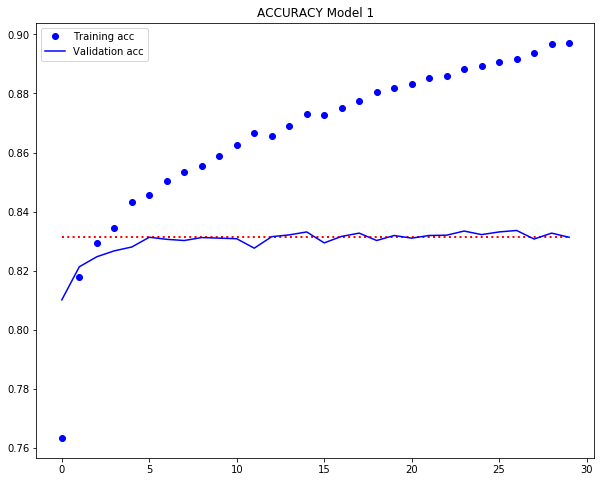

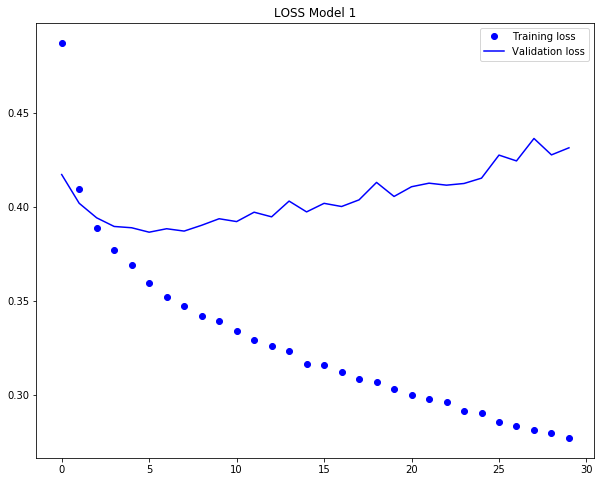

In [34]:
plot_hist(m1_hist, 'Model 1')

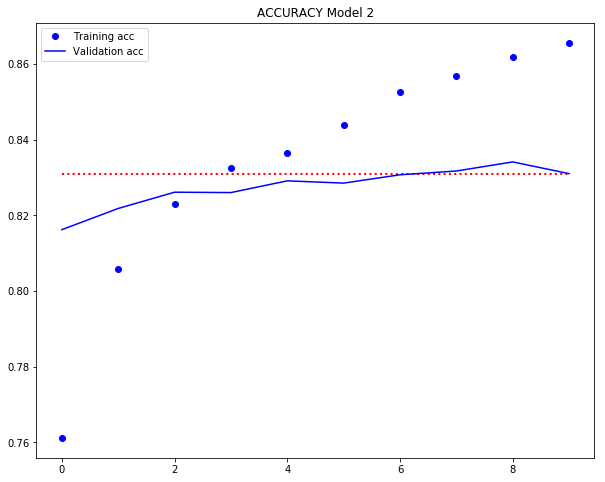

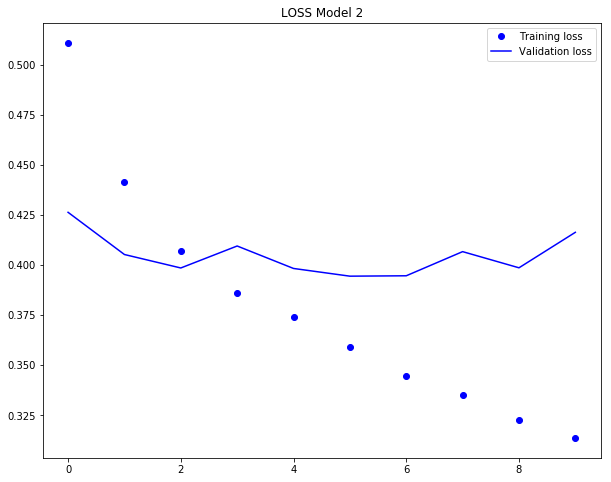

In [35]:
plot_hist(m2_hist, 'Model 2')

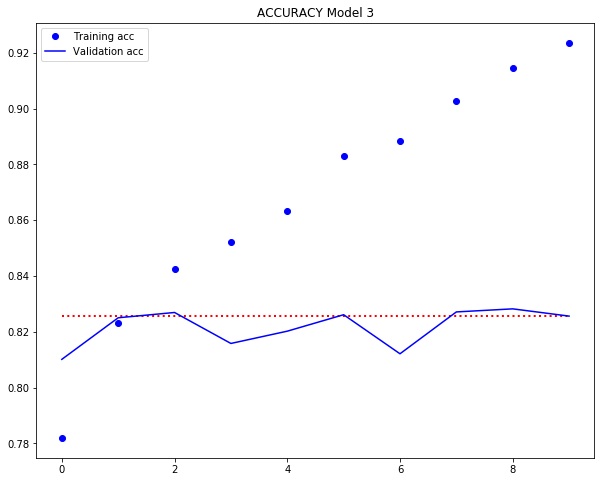

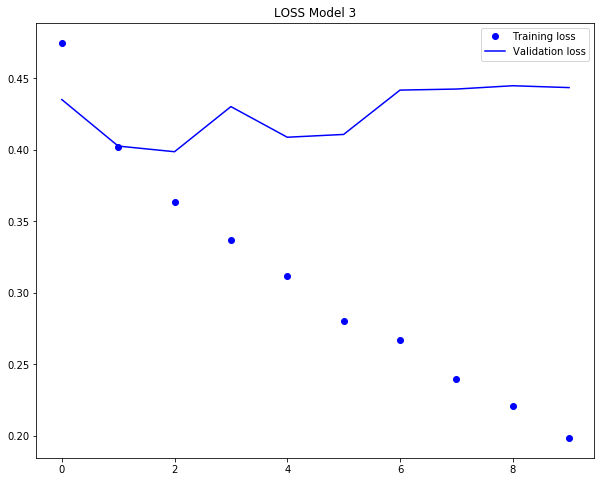

In [36]:
plot_hist(m3_hist, 'Model 3')

# Feature Extraction - InceptionV3

In [37]:
from keras.applications import InceptionV3
conv_base3 = InceptionV3(weights = 'imagenet', include_top=False, input_shape=(150, 150, 3))

In [38]:
def extract_features_I3(directory, sample_count):
    features = np.zeros(shape=(sample_count, 3, 3, 2048))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base3.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [39]:
train_features, train_labels = extract_features_I3(TRAIN_DIR, NB_TRAIN)
validation_features, validation_labels = extract_features_I3(VAL_DIR, NB_VAL)
test_features, test_labels = extract_features_I3(TEST_DIR, NB_TEST)
train_features = np.reshape(train_features, (NB_TRAIN, 3 * 3 * 2048))
validation_features = np.reshape(validation_features, (NB_VAL, 3 * 3 * 2048))
test_features = np.reshape(test_features, (NB_TEST, 3 * 3 * 2048))

Found 40000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [40]:
def create_model_FE_I3(neurons=256, dropout=0.5, bn=False):
    model = models.Sequential()
    model.add(layers.Dense(neurons, activation='relu', input_dim=3 * 3 * 2048))    
    if dropout >= 0.0:
        model.add(layers.Dropout(dropout))        
    if bn:
        model.add(layers.BatchNormalization())        
    model.add(layers.Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(
        optimizer = optimizers.RMSprop(lr=2e-5),
        loss = 'binary_crossentropy',
        metrics = ['acc'])
    return model

In [41]:
m4 = create_model_FE_I3()
m5 = create_model_FE_I3(1024)
m6 = create_model_FE_I3(1024, 0.2, True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 4,719,105
Trainable params: 4,719,105
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1024)              18875392  
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________


In [42]:
m4_hist = m4.fit(train_features, train_labels, epochs=30, batch_size=20,
                   validation_data=(validation_features, validation_labels))

Train on 20000 samples, validate on 10000 samples
Epoch 1/30
20000/20000 [==============================] - 9s 444us/step - loss: 0.4411 - acc: 0.8215 - val_loss: 0.3903 - val_acc: 0.8446
Epoch 2/30
20000/20000 [==============================] - 8s 391us/step - loss: 0.3830 - acc: 0.8478 - val_loss: 0.3844 - val_acc: 0.8405
Epoch 3/30
20000/20000 [==============================] - 8s 408us/step - loss: 0.3589 - acc: 0.8551 - val_loss: 0.3950 - val_acc: 0.8390
Epoch 4/30
20000/20000 [==============================] - 9s 428us/step - loss: 0.3389 - acc: 0.8657 - val_loss: 0.4069 - val_acc: 0.8456
Epoch 5/30
20000/20000 [==============================] - 8s 394us/step - loss: 0.3201 - acc: 0.8731 - val_loss: 0.4104 - val_acc: 0.8452
Epoch 6/30
20000/20000 [==============================] - 7s 370us/step - loss: 0.3028 - acc: 0.8776 - val_loss: 0.4048 - val_acc: 0.8426
Epoch 7/30
20000/20000 [==============================] - 8s 392us/step - loss: 0.2939 - acc: 0.8841 - val_loss: 0.4128 - 

In [43]:
m5_hist = m5.fit(train_features, train_labels, epochs=10, batch_size=20,
                   validation_data=(validation_features, validation_labels))

Train on 20000 samples, validate on 10000 samples
Epoch 1/10
20000/20000 [==============================] - 15s 734us/step - loss: 0.5018 - acc: 0.8167 - val_loss: 0.4056 - val_acc: 0.8333
Epoch 2/10
20000/20000 [==============================] - 14s 710us/step - loss: 0.3985 - acc: 0.8442 - val_loss: 0.3838 - val_acc: 0.8410
Epoch 3/10
20000/20000 [==============================] - 14s 693us/step - loss: 0.3617 - acc: 0.8572 - val_loss: 0.4159 - val_acc: 0.8400
Epoch 4/10
20000/20000 [==============================] - 15s 747us/step - loss: 0.3358 - acc: 0.8700 - val_loss: 0.4100 - val_acc: 0.8349
Epoch 5/10
20000/20000 [==============================] - 15s 732us/step - loss: 0.3083 - acc: 0.8798 - val_loss: 0.4237 - val_acc: 0.8400
Epoch 6/10
20000/20000 [==============================] - 15s 727us/step - loss: 0.2871 - acc: 0.8890 - val_loss: 0.4208 - val_acc: 0.8320
Epoch 7/10
20000/20000 [==============================] - 14s 716us/step - loss: 0.2619 - acc: 0.8997 - val_loss: 0.

In [44]:
m6_hist = m6.fit(train_features, train_labels, epochs=10, batch_size=20,
                   validation_data=(validation_features, validation_labels))

Train on 20000 samples, validate on 10000 samples
Epoch 1/10
20000/20000 [==============================] - 15s 752us/step - loss: 0.4651 - acc: 0.8112 - val_loss: 0.4138 - val_acc: 0.8357
Epoch 2/10
20000/20000 [==============================] - 15s 753us/step - loss: 0.3751 - acc: 0.8465 - val_loss: 0.4084 - val_acc: 0.8421
Epoch 3/10
20000/20000 [==============================] - 15s 741us/step - loss: 0.3294 - acc: 0.8653 - val_loss: 0.3995 - val_acc: 0.8392
Epoch 4/10
20000/20000 [==============================] - 15s 757us/step - loss: 0.2943 - acc: 0.8796 - val_loss: 0.4060 - val_acc: 0.8328
Epoch 5/10
20000/20000 [==============================] - 14s 716us/step - loss: 0.2612 - acc: 0.8930 - val_loss: 0.3980 - val_acc: 0.8424
Epoch 6/10
20000/20000 [==============================] - 14s 707us/step - loss: 0.2318 - acc: 0.9089 - val_loss: 0.4329 - val_acc: 0.8370
Epoch 7/10
20000/20000 [==============================] - 14s 715us/step - loss: 0.2053 - acc: 0.9214 - val_loss: 0.

In [45]:
loss4, acc4 = m4.evaluate(test_features, test_labels)
print("Model 4: Test Accuracy:", acc4)
loss5, acc5 = m5.evaluate(test_features, test_labels)
print("Model 5: Test Accuracy:", acc5)
loss6, acc6 = m6.evaluate(test_features, test_labels)
print("Model 6: Test Accuracy:", acc6)

10000/10000 [==============================] - 1s 104us/step
Model 4: Test Accuracy: 0.8386
10000/10000 [==============================] - 1s 117us/step
Model 5: Test Accuracy: 0.8396
10000/10000 [==============================] - 1s 111us/step
Model 6: Test Accuracy: 0.8377


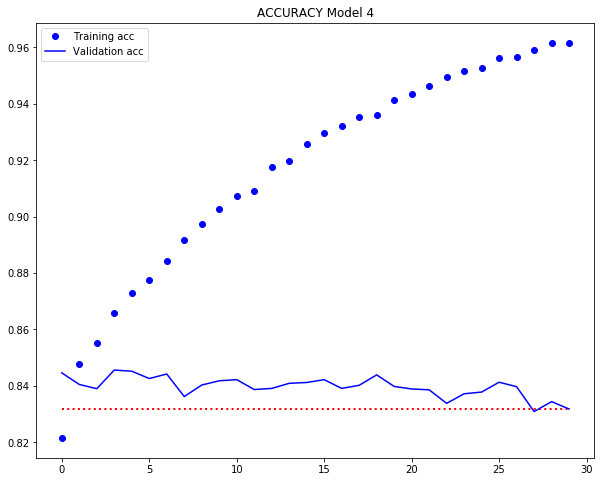

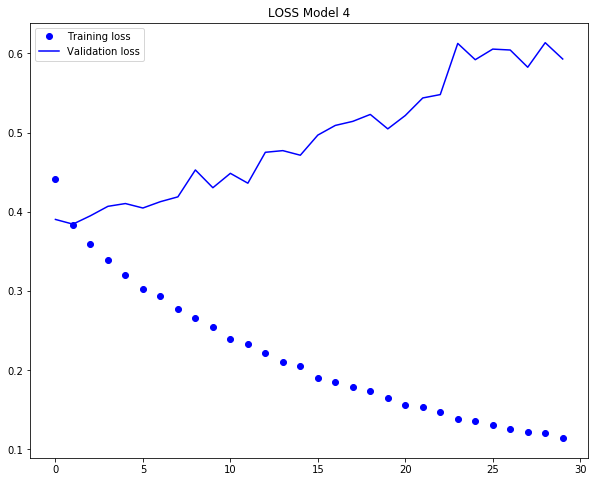

In [46]:
plot_hist(m4_hist, 'Model 4')

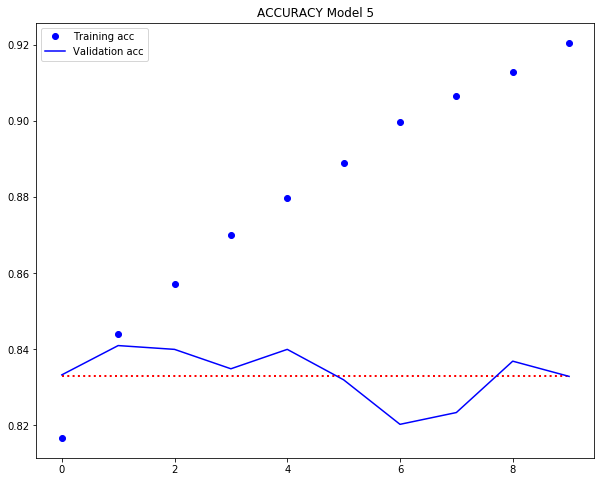

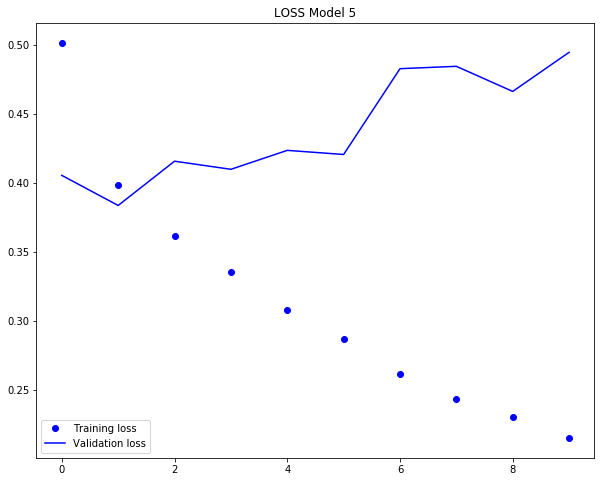

In [47]:
plot_hist(m5_hist, 'Model 5')

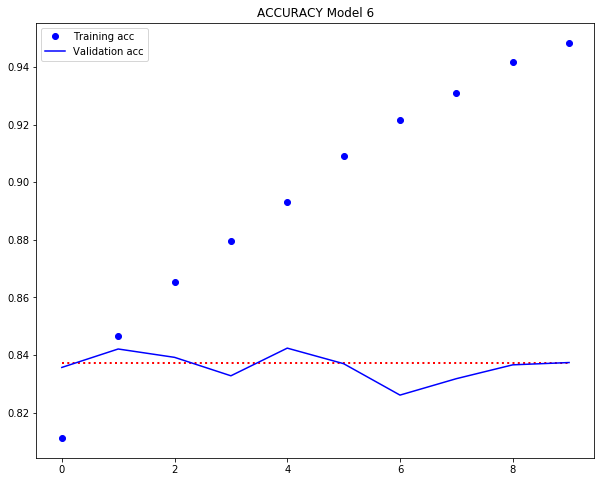

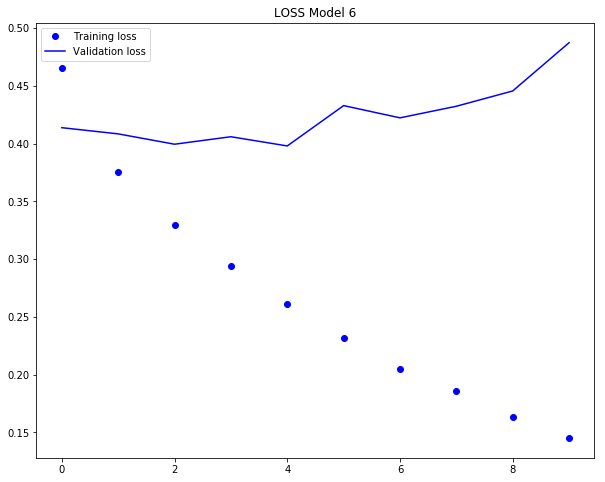

In [48]:
plot_hist(m6_hist, 'Model 6')

# Fine Tuning - VGG16

In [49]:
from keras.applications import  VGG16
conv_base_vgg16 = VGG16(weights = 'imagenet', include_top=False, input_shape=(150, 150, 3))

In [50]:
conv_base_vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [51]:
conv_base_vgg16.trainable = True
set_trainable = False
for layer in conv_base_vgg16.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [52]:
conv_base_vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [53]:
def create_model_FT_VGG16(neurons=256, dropout=0.5, bn=False):
    model = models.Sequential()
    model.add(conv_base_vgg16)
    model.add(layers.Flatten())
    model.add(layers.Dense(neurons, activation='relu'))
    if dropout > 0.0:
        model.add(layers.Dropout(dropout))
    if bn:
        model.add(layers.BatchNormalization())
    model.add(layers.Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
    return model

In [54]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Notar que la data de validacion no debe ser aumentada!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

val_generator = test_datagen.flow_from_directory(
        VAL_DIR,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 40000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [55]:
m7 = create_model_FT_VGG16()
m8 = create_model_FT_VGG16(1024)
m9 = create_model_FT_VGG16(1024, 0.5, True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Pa

In [56]:
m7_hist = m7.fit_generator(
      train_generator,  epochs=10,   steps_per_epoch=50,
      validation_data=val_generator, validation_steps=50, verbose=2)

Epoch 1/10
 - 6s - loss: 0.6678 - acc: 0.6110 - val_loss: 0.5156 - val_acc: 0.7410
Epoch 2/10
 - 5s - loss: 0.5946 - acc: 0.6750 - val_loss: 0.5138 - val_acc: 0.7360
Epoch 3/10
 - 5s - loss: 0.5562 - acc: 0.7120 - val_loss: 0.4429 - val_acc: 0.7890
Epoch 4/10
 - 5s - loss: 0.5031 - acc: 0.7470 - val_loss: 0.4258 - val_acc: 0.8090
Epoch 5/10
 - 5s - loss: 0.4910 - acc: 0.7710 - val_loss: 0.4172 - val_acc: 0.8160
Epoch 6/10
 - 5s - loss: 0.4750 - acc: 0.7630 - val_loss: 0.4405 - val_acc: 0.7990
Epoch 7/10
 - 5s - loss: 0.4490 - acc: 0.7920 - val_loss: 0.5416 - val_acc: 0.7680
Epoch 8/10
 - 5s - loss: 0.4269 - acc: 0.8100 - val_loss: 0.3961 - val_acc: 0.8220
Epoch 9/10
 - 5s - loss: 0.4469 - acc: 0.7830 - val_loss: 0.4082 - val_acc: 0.8120
Epoch 10/10
 - 5s - loss: 0.4124 - acc: 0.8140 - val_loss: 0.4058 - val_acc: 0.8240


In [57]:
loss7, acc7 = m7.evaluate_generator(test_generator, steps=100)
print('Model 7 - Test Accuracy:', acc7)

Model 7 - Test Accuracy: 0.8240000027418136


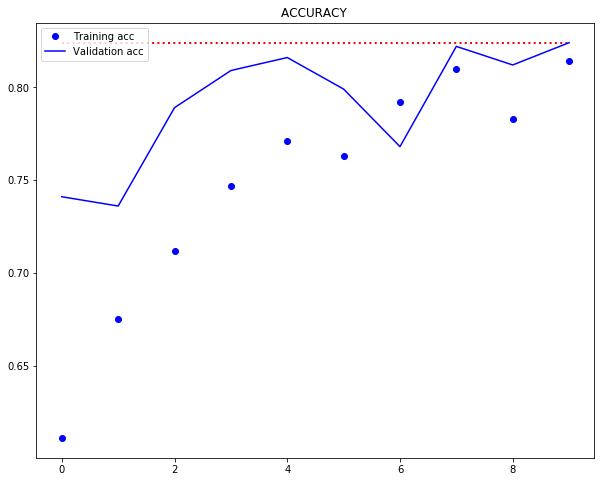

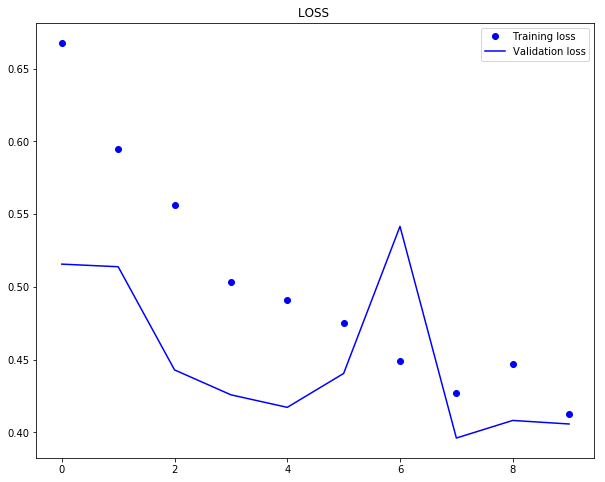

In [58]:
plot_hist(m7_hist)

In [59]:
m7_hist = m7.fit_generator(
      train_generator,  epochs=10,   steps_per_epoch=100,
      validation_data=val_generator, validation_steps=50, verbose=1)

Epoch 1/10
100/100 [==============================] - 9s 90ms/step - loss: 0.4348 - acc: 0.8015 - val_loss: 0.3779 - val_acc: 0.8280
Epoch 2/10
100/100 [==============================] - 8s 83ms/step - loss: 0.4064 - acc: 0.8200 - val_loss: 0.3847 - val_acc: 0.8300
Epoch 3/10
100/100 [==============================] - 8s 82ms/step - loss: 0.3947 - acc: 0.8160 - val_loss: 0.3692 - val_acc: 0.8270
Epoch 4/10
100/100 [==============================] - 8s 83ms/step - loss: 0.4158 - acc: 0.8230 - val_loss: 0.3815 - val_acc: 0.8280
Epoch 5/10
100/100 [==============================] - 8s 85ms/step - loss: 0.4161 - acc: 0.8095 - val_loss: 0.3711 - val_acc: 0.8340
Epoch 6/10
100/100 [==============================] - 8s 83ms/step - loss: 0.3797 - acc: 0.8260 - val_loss: 0.3628 - val_acc: 0.8420
Epoch 7/10
100/100 [==============================] - 8s 83ms/step - loss: 0.3908 - acc: 0.8345 - val_loss: 0.3599 - val_acc: 0.8410
Epoch 8/10
100/100 [==============================] - 8s 84ms/step - 

In [60]:
loss7, acc7 = m7.evaluate_generator(test_generator, steps=100)
print('Model 7 - Test Accuracy:', acc7)

Model 7 - Test Accuracy: 0.8430000007152557


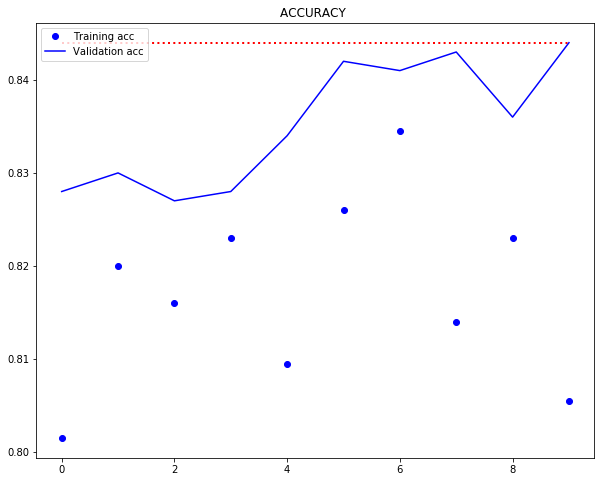

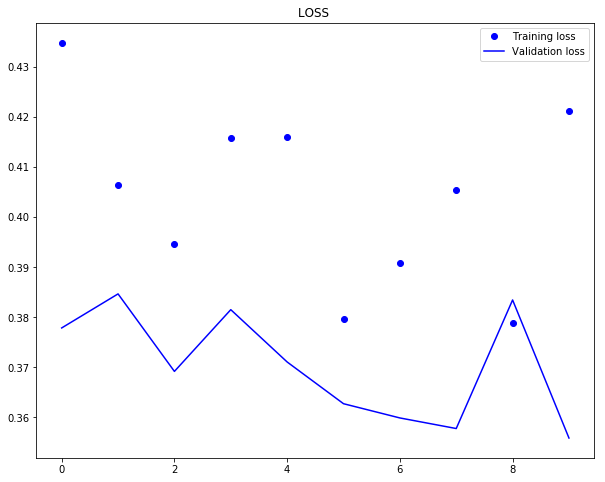

In [61]:
plot_hist(m7_hist)

# Feature Extraction - MobileNet

In [62]:
from keras.applications import MobileNet
conv_base_mob = MobileNet(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))

In [63]:
datagen4 = ImageDataGenerator(rescale=1.0/255)

In [64]:
def extract_features_MOB(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 1024))
    labels = np.zeros(shape=(sample_count))
    generator = datagen4.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base_mob.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [65]:
train_features, train_labels = extract_features_MOB(TRAIN_DIR, NB_TRAIN)
validation_features, validation_labels = extract_features_MOB(VAL_DIR, NB_VAL)
test_features, test_labels = extract_features_MOB(TEST_DIR, NB_TEST)

Found 40000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [66]:
DIM_SIZE = 7 * 7 * 1024

In [67]:
train_features = np.reshape(train_features, (NB_TRAIN, DIM_SIZE))
validation_features = np.reshape(validation_features, (NB_VAL, DIM_SIZE))
test_features = np.reshape(test_features, (NB_TEST, DIM_SIZE))

In [68]:
def create_model_MOB(neurons=256, dropout=0.5, bn=False):
    model = models.Sequential()
    model.add(layers.Dense(neurons, activation='relu', input_dim=DIM_SIZE))
    if dropout > 0.0:
        model.add(layers.Dropout(dropout))
    if bn:
        model.add(layers.Batch_Normalization())
    model.add(layers.Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(
        optimizer = optimizers.RMSprop(lr=2e-5),
        loss = 'binary_crossentropy',
        metrics = ['acc'])
    return model

In [69]:
m10 = create_model_MOB()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 256)               12845312  
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 257       
Total params: 12,845,569
Trainable params: 12,845,569
Non-trainable params: 0
_________________________________________________________________


In [70]:
m10_hist = m10.fit(train_features, train_labels,
                 epochs=10,
                 batch_size=20,
                 validation_data=(validation_features, validation_labels))

Train on 20000 samples, validate on 10000 samples
Epoch 1/10
20000/20000 [==============================] - 15s 768us/step - loss: 0.4507 - acc: 0.8196 - val_loss: 0.3718 - val_acc: 0.8536
Epoch 2/10
20000/20000 [==============================] - 15s 726us/step - loss: 0.3603 - acc: 0.8646 - val_loss: 0.3743 - val_acc: 0.8569
Epoch 3/10
20000/20000 [==============================] - 14s 699us/step - loss: 0.3145 - acc: 0.8862 - val_loss: 0.4318 - val_acc: 0.8434
Epoch 4/10
20000/20000 [==============================] - 15s 749us/step - loss: 0.2727 - acc: 0.9022 - val_loss: 0.4825 - val_acc: 0.8456
Epoch 5/10
20000/20000 [==============================] - 14s 713us/step - loss: 0.2388 - acc: 0.9158 - val_loss: 0.4706 - val_acc: 0.8465
Epoch 6/10
20000/20000 [==============================] - 15s 727us/step - loss: 0.2062 - acc: 0.9289 - val_loss: 0.4968 - val_acc: 0.8470
Epoch 7/10
20000/20000 [==============================] - 15s 727us/step - loss: 0.1857 - acc: 0.9395 - val_loss: 0.

In [71]:
loss10, acc10 = m10.evaluate(test_features, test_labels)
print('Model 10 - Test Accuracy:', acc10)

10000/10000 [==============================] - 2s 172us/step
Model 10 - Test Accuracy: 0.8388


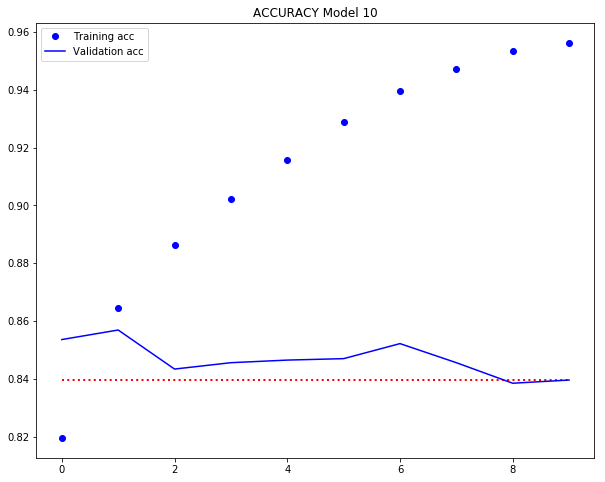

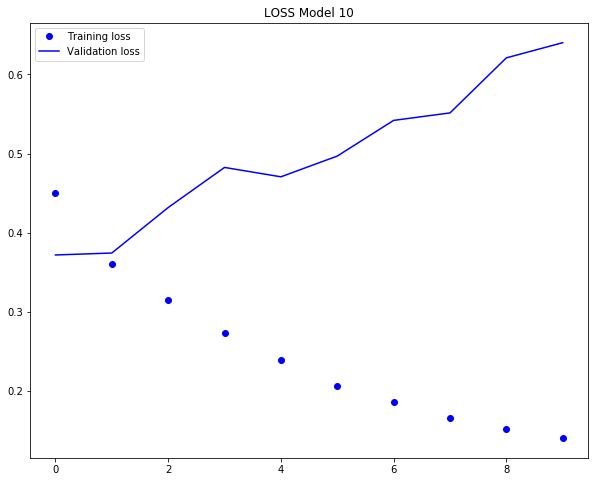

In [72]:
plot_hist(m10_hist, 'Model 10')